In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import pandas as pd

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
path = '/content/drive/MyDrive/RecSys/'

In [ ]:
### Load the main data

data = np.loadtxt(path+'ratings.csv', skiprows=1, delimiter=',')
np.random.shuffle(data)


In [ ]:
### Upload the Movie data
movie = pd.read_csv(path+'movies.csv')

In [ ]:
genre = movie['genres']

## Get unique genre

In [ ]:
all_genres = {}
for row in movie['genres']:
    _genre = row.split('|')
    for unique_genre in _genre:
        if unique_genre not in all_genres:
            all_genres[unique_genre] = len(all_genres)

# genre2Id = genres_split.apply(lambda x: [genre_to_id[genre] for genre in x])
genre_split = movie['genres'].str.split('|')
genre2Id = genre_split.apply(lambda x: [all_genres[genre] for genre in x])

## Genre to Id

In [ ]:
movie['genreId'] = genre2Id

In [ ]:
### Create the sparse matrix

def sparse_matrix(data):

    # Extract user, movie, rating columns from data
    user, movie, rating = data[:, 0], data[:, 1], data[:, 2]

    # mapping from user to index
    map_user_to_index = {}
    map_index_to_user = []

    # mapping from movie to index
    map_movie_to_index = {}
    map_index_to_movie = []


    for user_id, movie_id  in zip(user, movie):
        if user_id not in map_user_to_index.keys():
            index_user = len(map_index_to_user)
            map_index_to_user.append(user_id)
            map_user_to_index[user_id] = index_user
        else:
            index_user = map_user_to_index[user_id]

        if movie_id not in map_movie_to_index.keys():
            index_movie = len(map_index_to_movie)
            map_index_to_movie.append(movie_id)
            map_movie_to_index[movie_id] = index_movie
        else:
            index_movie = map_movie_to_index[movie_id]

    #Initialize with empty list all the trainings data.
    user_data_train = [[] for i in range(len(map_index_to_user))]
    movie_data_train = [[] for i in range(len(map_index_to_movie))]

    #Initialize with empty list all the test data.
    user_data_test = [[] for i in range(len(map_index_to_user))]
    movie_data_test = [[] for i in range(len(map_index_to_movie))]

    counter = 0
    for U_Id, M_Id, rat in zip(user, movie, rating):
        User_Id = map_user_to_index[U_Id]
        Movie_Id = map_movie_to_index[M_Id]

        if counter < int(0.9 * len(data)):  # Put 90% of the data into the training data
            user_data_train[User_Id].append((Movie_Id, rat))
            movie_data_train[Movie_Id].append((User_Id, rat))
        else:
            user_data_test[User_Id].append((Movie_Id, rat))
            movie_data_test[Movie_Id].append((User_Id, rat))
        counter += 1

    return user_data_train, movie_data_train, user_data_test, movie_data_test, map_user_to_index, map_index_to_user, map_movie_to_index, map_index_to_movie

user_data_train, movie_data_train, user_data_test, movie_data_test, map_user_to_index, map_index_to_user, map_movie_to_index, map_index_to_movie = sparse_matrix(data)

In [ ]:

## Create function to count user
def counting(data_list):
    num_entries = [len(data) for data in data_list]
    count_entries = Counter(num_entries)
    x_values, y_values = zip(*count_entries.items())
    return x_values, y_values

## Count user/movie train
x_user_train_count, y_user_train_count = counting(user_data_train)
x_movie_train_count, y_movie_train_count = counting(movie_data_train)

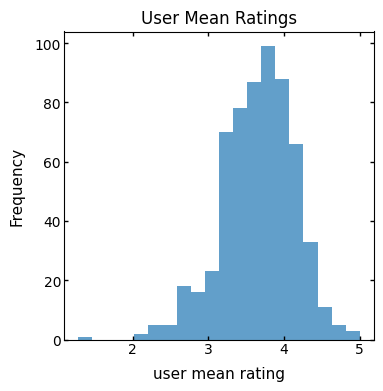

In [ ]:
### Plot the rating distribution

def plot_mean_ratings(x_label, data_column, name):
    ratings = data[:, 2]
    unique_values = np.unique(data_column)
    mean_ratings = []

    for value in unique_values:
        value_ratings = ratings[data_column == value]
        mean_rating = np.mean(value_ratings)
        mean_ratings.append(mean_rating)

    plt.figure(figsize=(4, 4))
    ax = plt.gca()
    ax.hist(mean_ratings, bins=20, alpha=0.7)
    ax.set_xlabel(x_label, labelpad=7, fontsize=11)
    ax.set_ylabel('Frequency', labelpad=7, fontsize=11)
    ax.tick_params(axis='both', which='both', direction='in', length=3, width=1, pad=2, top=True, right=True)
    plt.title(f'{name} Mean Ratings')
    plt.savefig(name+'_Mean_Rating.pdf', bbox_inches="tight", dpi=400)
    plt.show()

### User mean rating
user_column = data[:, 0]
plot_mean_ratings('user mean rating', user_column, 'User')

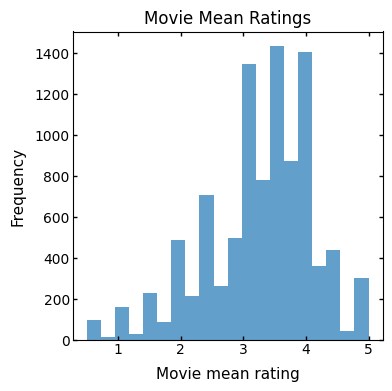

In [ ]:
### Movie mean rating
movie_column = data[:, 1]
plot_mean_ratings('Movie mean rating', movie_column, 'Movie')

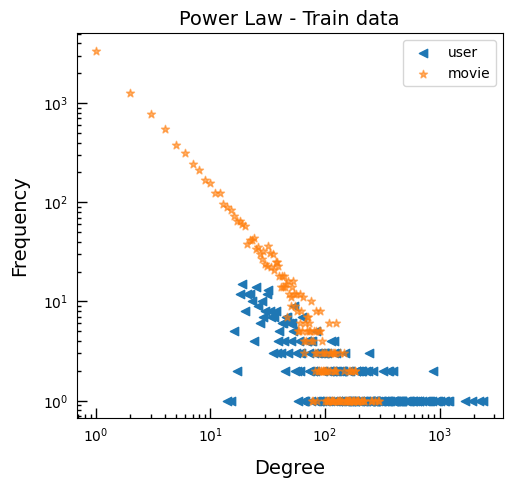

In [ ]:
### Function to Plot Power Law

def plot_power_law(x_user_data, y_user_data, x_movie_data, y_movie_data, Figure_name, Plot_title):

    # plot initialization

    plt.figure(figsize=(5.5, 5))
    plt.gca()
    plt.xscale('log')
    plt.yscale('log')
    ax = plt.gca()

    # scatter plot

    ax.scatter(x_user_data, y_user_data, marker='<')
    ax.scatter(x_movie_data, y_movie_data, marker='*', alpha=0.6)

    # axis plot

    ax.set_xlabel('Degree', labelpad=10, fontsize=14)
    ax.set_ylabel('Frequency', labelpad=10, fontsize=14)
    ax.set_title(Plot_title, fontsize=14)
    ax.tick_params(axis='both', which='both', direction='in', length=7, width=1, pad=6)
    ax.tick_params(which='minor', length=3)
    ax.legend(["user", "movie"], loc ="upper right")

    # save figure

    plt.savefig(Figure_name+'.pdf', bbox_inches="tight", dpi=400)
    plt.show()


### Plot the power law
plot_power_law(x_user_train_count, y_user_train_count, x_movie_train_count, y_movie_train_count, 'Train_data', 'Power Law - Train data')

In [ ]:
# Transform it into dictionary
movie_dict = {}
for index, row in movie.iterrows():
    movie_id = row['movieId']
    title = row['title']
    genres = row['genres']
    movie_dict[movie_id] = {'title': title, 'genres': genres}

# Initialize the mappings
genre_to_movies = {}
movie_to_genres = {}

# Populate the mappings
for movie_index, movie_info in movie_dict.items():
    if movie_index in map_movie_to_index:
        movie_internal_index = map_movie_to_index[movie_index]
        genres = movie_info['genres'].split('|')

        for genre in genres:
            if genre not in genre_to_movies:
                genre_to_movies[genre] = []
            genre_to_movies[genre].append(movie_internal_index)

            if movie_internal_index not in movie_to_genres:
                movie_to_genres[movie_internal_index] = []
            movie_to_genres[movie_internal_index].append(genre)


In [ ]:
### Hyperparameter Initialization

lmbda = 0.005       # <--- lambda
tau = 0.01
gamma = 0.5
latent_dim = 10      # <--- K
mu = 0
sigma = 1/np.sqrt(latent_dim)
feature_dim = len(genre_to_movies)

In [ ]:
#### Compute and update biases
def compute_bias(sparse_user,
                 sparse_movie,
                 user_matrix,
                 movie_matrix,
                 user_bias,
                 movie_bias
                ):

    # Update user biases
    for user_Id in range(len(sparse_user)):
        bias = 0
        movie_counter = 0
        for movie_Id, rat in sparse_user[user_Id]:
            bias += lmbda * (rat- (np.dot(user_matrix[user_Id,:].T, movie_matrix[movie_Id,:]) + movie_bias[movie_Id]))
            movie_counter += 1

        bias = bias/ (lmbda * movie_counter + gamma)
        user_bias[user_Id] = bias

    # Update movie biases
    for movie_Id in range(len(sparse_movie)):
        bias = 0
        user_counter = 0
        for user_Id, rat in sparse_movie[movie_Id]:
            bias += lmbda * (rat - (np.dot(movie_matrix[movie_Id,:].T, user_matrix[user_Id,:]) + user_bias[user_Id]))
            user_counter += 1
        bias = bias/ (lmbda * user_counter + gamma)
        movie_bias[movie_Id] = bias

In [ ]:
def update_matrices(
        sparse_user,
        sparse_movie,
        user_matrix,
        movie_matrix,
        user_bias,
        movie_bias
                    ):

    # Update user matrix
    for user_Id in range(len(sparse_user)):
        if not sparse_user[user_Id]:
            continue

        U_left = 0
        U_right = 0

        for movie_Id, rat in sparse_user[user_Id]:
            U_left += lmbda * np.outer(movie_matrix[movie_Id,:], movie_matrix[movie_Id,:])
            U_right += lmbda * movie_matrix[movie_Id] * (rat - user_bias[user_Id] - movie_bias[movie_Id])

        U_left += tau * np.eye(latent_dim)
        user_matrix[user_Id] = np.dot(np.linalg.inv(U_left), U_right)

    # Update movie matrix
    for movie_Id in range(len(sparse_movie)):
        if not sparse_movie[movie_Id]:
            continue

        M_left = 0
        M_right = 0
        for user_Id, rat in sparse_movie[movie_Id]:
            M_left += lmbda * np.outer(user_matrix[user_Id,:], user_matrix[user_Id,:])
            M_right += lmbda * user_matrix[user_Id] * (rat - movie_bias[movie_Id] - user_bias[user_Id])

        M_left += tau * np.eye(latent_dim)
        movie_matrix[movie_Id] = np.dot(np.linalg.inv(M_left), M_right)

In [ ]:
### Compute Root Mean Square Error
def root_mean_square(user_data, user_matrix, movie_matrix, user_bias, movie_bias):

    err = 0
    num_rating = 0

    for user_Id in range(len(user_data)):
        for movie_Id ,rating in user_data[user_Id]:
            pred = (user_matrix[user_Id].T @ movie_matrix[movie_Id] + user_bias[user_Id] + movie_bias[movie_Id])
            err += (rating - pred) ** 2
        num_rating += len(user_data[user_Id])

    Error = err / num_rating

    return np.sqrt(Error)

In [ ]:
# Initialize feature vectors
feature_vector = {}
for genre in genre_to_movies:
    feature_vector[genre] = np.random.normal(mu, sigma, size=(latent_dim))

def update_features(features):
    for feature_index in features:
        s_fn = 0
        s_vec = np.zeros(latent_dim)
        feature_items = genre_to_movies[feature_index]
        for item_index in feature_items:
            fn = len(movie_to_genres[item_index])
            s_fn = s_fn + 1 / fn
            s_fl = np.zeros(latent_dim)
            for l in movie_to_genres[item_index]:
                if l != feature_index:
                    s_fl = s_fl + feature_vector[l]

            s_vec = s_vec + movie_matrix_train[item_index] / np.sqrt(fn) - 1 / fn * s_fl
        feature_vector[feature_index] = (1 / (1 + s_fn)) * s_vec

In [ ]:
# @title Loss
# ### Compute loss function
# def loss_function(
#         user_data,
#         movie_data,
#         user_matrix,
#         movie_matrix,
#         user_Bias,
#         movie_Bias
#         ):

#     diff = 0
#     user_sum = 0
#     movie_sum = 0

#     for userId in range(len(user_data)):
#         for movieId, rat in user_data[userId]:
#             if len(user_data[userId])==0:
#                 continue
#             else:
#                 matrix_user_movie = np.dot(user_matrix[userId,:].T, movie_matrix[movieId,:])
#                 diff += (rat - (matrix_user_movie + user_Bias[userId] + movie_Bias[movieId]))**2

#     for U_id in range(len(user_data)):
#         user_sum += np.dot(user_matrix[U_id].T, user_matrix[U_id])


#     for M_id in range(len(movie_data)):
#         movie_sum += np.dot(movie_matrix[M_id].T, movie_matrix[M_id])

#     U = np.dot(user_Bias, user_Bias)
#     V = np.dot(movie_Bias, movie_Bias)

#     loss = ((lmbda*diff) + (gamma*U) + (tau*user_sum) + (gamma*V) + (tau*movie_sum))/2

#     return loss

In [ ]:
def loss_function(
        user_data,
        movie_data,
        user_matrix,
        movie_matrix,
        user_Bias,
        movie_Bias,
        feature_vector
        ):

    diff = 0
    user_sum = 0
    movie_sum = 0
    feature_sum = 0

    for userId in range(len(user_data)):
        for movieId, rat in user_data[userId]:
            if len(user_data[userId]) == 0:
                continue
            else:
                matrix_user_movie = np.dot(user_matrix[userId,:].T, movie_matrix[movieId,:])
                diff += (rat - (matrix_user_movie + user_Bias[userId] + movie_Bias[movieId]))**2

    for U_id in range(len(user_data)):
        user_sum += np.dot(user_matrix[U_id].T , user_matrix[U_id])

    for M_id in range(len(movie_data)):
        fn = len(movie_to_genres[M_id])
        genre_sum = np.zeros(latent_dim)

        for genre in movie_to_genres[M_id]:
            genre_sum += feature_vector[genre]

        movie_vector = movie_matrix[M_id] - (1 / np.sqrt(fn)) * genre_sum
        movie_sum += np.dot(movie_vector.T, movie_vector)

    for feature in feature_vector:
        feature_sum += np.dot(feature_vector[feature].T, feature_vector[feature])

    U = np.dot(user_Bias, user_Bias)
    V = np.dot(movie_Bias, movie_Bias)

    loss = ((lmbda*diff) + (gamma*U) + (tau*user_sum) + (gamma*V) + (tau*movie_sum) + (tau*feature_sum))/2

    return loss


In [ ]:
# @title Default title text
### Create function for plotting
def plot_(iteration_number, loss_values_train, loss_values_test, ylabel, Figure_name, plot_title):

    # Plot initialization
    plt.figure(figsize=(10, 6))
    plt.gca()
    ax = plt.gca()

    # Plot the training loss with a blue line
    plt.plot(iteration_number, loss_values_train, marker='o', color='black', label="Training Loss")

    # Plot the test loss with a red line
    plt.plot(iteration_number, loss_values_test, marker='o', color='red', label="Test Loss")

    # x and y label
    ax.set_xlabel('Iteration', labelpad=10, fontsize=14)
    ax.set_ylabel(ylabel+'value', labelpad=10, fontsize=14)

    # Plot title
    ax.set_title(plot_title, fontsize=14)

    # Add a legend to the plot
    plt.legend()
    plt.grid(True)

    ax.tick_params(axis='both', which='both', direction='in', length=5, width=1, pad=6)
    ax.tick_params(which='minor', length=3)

    # Remove top and right axis
    ax.spines[['right', 'top']].set_visible(False)

    # Save figure
    plt.savefig(Figure_name+'.pdf', bbox_inches="tight", dpi=400)
    plt.show()

In [ ]:
# train matrices

user_matrix_train = np.random.normal(mu, sigma, size=(len(user_data_train), latent_dim))
movie_matrix_train = np.random.normal(mu, sigma, size=(len(movie_data_train), latent_dim))
user_biases_train = np.zeros((len(user_data_train)))
movie_biases_train = np.zeros((len(movie_data_train)))

# test matrices

user_matrix_test = np.random.normal(mu, sigma, size=(len(user_data_test), latent_dim))
movie_matrix_test = np.random.normal(mu, sigma, size=(len(movie_data_test), latent_dim))
user_biases_test = np.zeros((len(user_data_test)))
movie_biases_test = np.zeros((len(movie_data_test)))

In [ ]:
### With feature vector
#### Traind the model
def train_and_evaluate(iteration):
    iteration_number, loss_values_train, loss_values_test, error_train, error_test = [], [], [], [], []

    for iter in range(iteration):
        # loss function for the train data
        compute_bias(user_data_train,
                     movie_data_train,
                     user_matrix_train,
                     movie_matrix_train,
                     user_biases_train,
                     movie_biases_train)

        update_matrices(user_data_train,
                        movie_data_train,
                        user_matrix_train,
                        movie_matrix_train,
                        user_biases_train,
                        movie_biases_train)

        update_features(genre_to_movies.keys())

        loss_values_train.append(loss_function(
            user_data_train,
            movie_data_train,
            user_matrix_train,
            movie_matrix_train,
            user_biases_train,
            movie_biases_train,
            feature_vector
            )
        )

        # loss function for the test data
        compute_bias(user_data_test,
                     movie_data_test,
                     user_matrix_test,
                     movie_matrix_test,
                     user_biases_test,
                     movie_biases_test)

        update_matrices(user_data_test,
                        movie_data_test,
                        user_matrix_test,
                        movie_matrix_test,
                        user_biases_test,
                        movie_biases_test)

        loss_values_test.append(loss_function(user_data_test,
                                              movie_data_test,
                                              user_matrix_test,
                                              movie_matrix_test,
                                              user_biases_test,
                                              movie_biases_test,
                                              feature_vector))

        rmse_train = root_mean_square(user_data_train,
                                      user_matrix_train,
                                      movie_matrix_train,
                                      user_biases_train,
                                      movie_biases_train)

        rmse_test = root_mean_square(user_data_test,
                                     user_matrix_test,
                                     movie_matrix_test,
                                     user_biases_test,
                                     movie_biases_test)

        error_train.append(rmse_train)
        error_test.append(rmse_test)

        iteration_number.append(iter)

    return loss_values_train, loss_values_test, error_train, error_test, iteration_number

In [ ]:
# @title Default title text

# #### Traind the model

# def train_and_evaluate(iteration):
#     iteration_number, loss_values_train, loss_values_test, error_train, error_test = [], [], [], [], []

#     for iter in range(iteration):
#         # loss function for the train data
#         compute_bias(user_data_train,
#                      movie_data_train,
#                      user_matrix_train,
#                      movie_matrix_train,
#                      user_biases_train,
#                      movie_biases_train)

#         update_matrices(user_data_train,
#                         movie_data_train,
#                         user_matrix_train,
#                         movie_matrix_train,
#                         user_biases_train,
#                         movie_biases_train)

#         loss_values_train.append(loss_function(
#             user_data_train,
#             movie_data_train,
#             user_matrix_train,
#             movie_matrix_train,
#             user_biases_train,
#             movie_biases_train
#             )
#         )

#         # loss function for the test data
#         compute_bias(user_data_test,
#                      movie_data_test,
#                      user_matrix_test,
#                      movie_matrix_test,
#                      user_biases_test,
#                      movie_biases_test)

#         update_matrices(user_data_test,
#                         movie_data_test,
#                         user_matrix_test,
#                         movie_matrix_test,
#                         user_biases_test,
#                         movie_biases_test)

#         loss_values_test.append(loss_function(user_data_test,
#                                               movie_data_test,
#                                               user_matrix_test,
#                                               movie_matrix_test,
#                                               user_biases_test,
#                                               movie_biases_test))

#         rmse_train = root_mean_square(user_data_train,
#                                       user_matrix_train,
#                                       movie_matrix_train,
#                                       user_biases_train,
#                                       movie_biases_train)

#         rmse_test = root_mean_square(user_data_test,
#                                      user_matrix_test,
#                                      movie_matrix_test,
#                                      user_biases_test,
#                                      movie_biases_test)

#         error_train.append(rmse_train)
#         error_test.append(rmse_test)

#         iteration_number.append(iter)

#     return loss_values_train, loss_values_test, error_train, error_test, iteration_number

In [ ]:
iteration = 12
loss_train, loss_test, error_train, error_test, iteration_number = train_and_evaluate(iteration)

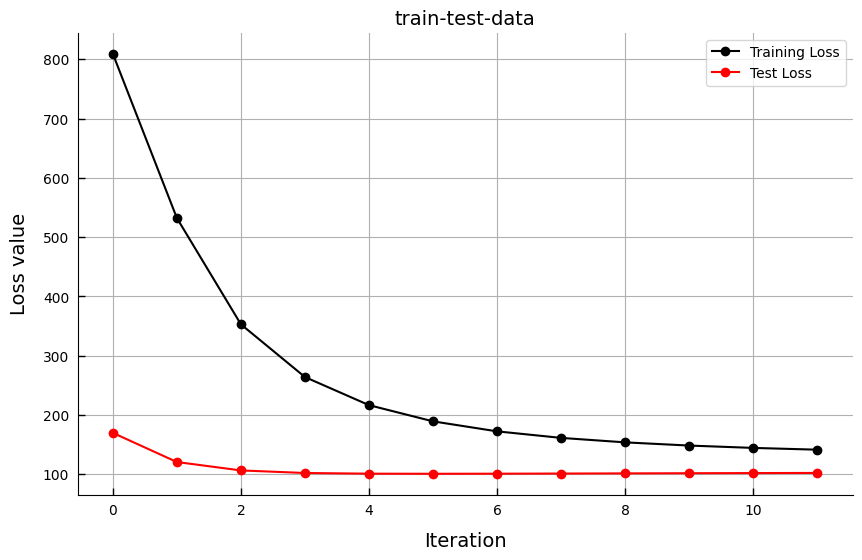

In [ ]:
### Plot the loss function
plot_(iteration_number, loss_train, loss_test, 'Loss ', 'Loss_train_test', 'train-test-data')

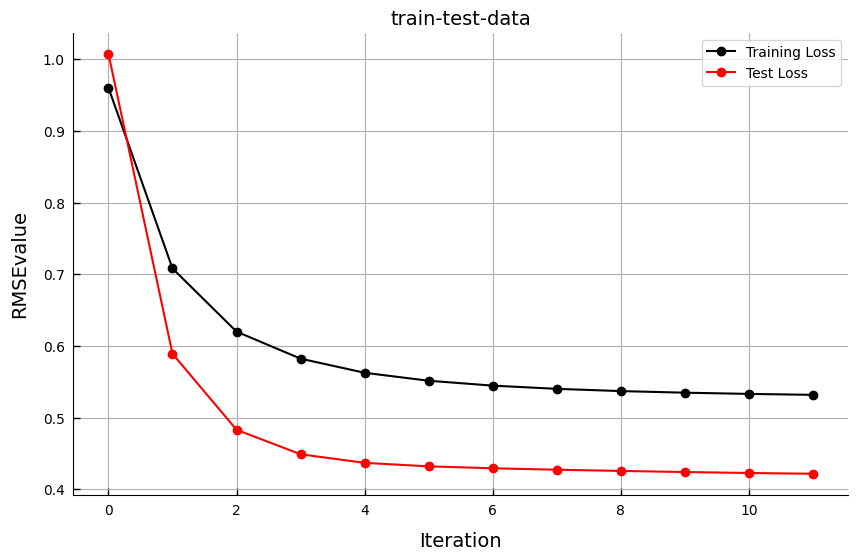

In [ ]:
plot_(iteration_number, error_train, error_test, 'RMSE', 'RMSE_train_test', 'train-test-data')

In [ ]:
### Map movie title and genre
def get_movie_title(movie_index):
    movie_sys = map_index_to_movie[movie_index]
    movie_title = movie_dict[movie_sys]['title']
    return movie_title

In [ ]:
def get_movie_genre(movie_index):
    movie_sys = map_index_to_movie[movie_index]
    movie_genres = movie_dict[movie_sys]['genres']
    return movie_genres

In [ ]:
### Function to search movie title in movie.csv
def search_movieId_by_title(title_to_search):

    movie_results = []
    title_to_search = title_to_search.lower()

    for movie_id, movie_info in movie_dict.items():
        if title_to_search in movie_info['title'].lower():
            if movie_id in map_movie_to_index:
                movie_results.append([map_movie_to_index[movie_id], movie_info['title'], movie_info['genres']])

    return movie_results

In [ ]:
### Create a function for the prediction
def recommend_movies(
        new_user_matrix,
        movie_matrix,
        movie_biases,
        num_recommendations=15,
        regularization_factor=0.9):

    _recommended_movies = []

    # Calculate preference scores for each movie
    for movie_id in range(len(movie_matrix)):
        preference_score = np.dot(
            new_user_matrix,
            movie_matrix[movie_id, :]
            ) + regularization_factor * movie_biases[movie_id]

        _recommended_movies.append((movie_id, preference_score))

    # Sort movies by preference score in descending order
    _recommended_movies = sorted(_recommended_movies, key=lambda x: x[1], reverse=True)

    # Get the top N recommended movies
    _recommended_movies = _recommended_movies[:num_recommendations]

    return _recommended_movies

In [ ]:
new_user_movie_Id = 1234
new_user_matrix = movie_matrix_train[new_user_movie_Id].copy()

result_recommend_movies = recommend_movies(new_user_matrix, movie_matrix_train, movie_biases_train)

new_user_movie_title = get_movie_title(new_user_movie_Id)
new_user_movie_title_genre = get_movie_genre(new_user_movie_Id)
print(f"The new user watched:\n{new_user_movie_title}\t{new_user_movie_title_genre}\n")

print(f'The new user may also like: \n')
for Id in result_recommend_movies:
    print(Id[0], get_movie_title(Id[0]), '\t',get_movie_genre(Id[0]))

The new user watched:
Tale of Two Sisters, A (Janghwa, Hongryeon) (2003)	Drama|Horror|Mystery|Thriller

The new user may also like: 

3634 Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984) 	 Adventure|Animation|Drama|Fantasy|Sci-Fi
1887 All About My Mother (Todo sobre mi madre) (1999) 	 Drama
5645 High Noon (1952) 	 Drama|Western
1260 Hannah and Her Sisters (1986) 	 Comedy|Drama|Romance
1679 Bottle Rocket (1996) 	 Adventure|Comedy|Crime|Romance
396 James and the Giant Peach (1996) 	 Adventure|Animation|Children|Fantasy|Musical
393 Double Indemnity (1944) 	 Crime|Drama|Film-Noir
1908 12 Angry Men (1957) 	 Drama
3043 Wild Tales (2014) 	 Comedy|Drama|Thriller
6396 Barcelona (1994) 	 Comedy|Romance
1199 M (1931) 	 Crime|Film-Noir|Thriller
1176 Manhattan (1979) 	 Comedy|Drama|Romance
108 Pulp Fiction (1994) 	 Comedy|Crime|Drama|Thriller
5674 Persepolis (2007) 	 Animation|Drama
394 Big Lebowski, The (1998) 	 Comedy|Crime


In [ ]:
new_user_movie_Id = 12
new_user_matrix = movie_matrix_train[new_user_movie_Id].copy()

result_recommend_movies = recommend_movies(new_user_matrix, movie_matrix_train, movie_biases_train)

new_user_movie_title = get_movie_title(new_user_movie_Id)
new_user_movie_title_genre = get_movie_genre(new_user_movie_Id)
print(f"The new user watched:\n{new_user_movie_title}\t{new_user_movie_title_genre}\n")

print(f'The new user may also like: \n')
for Id in result_recommend_movies:
    print(Id[0], get_movie_title(Id[0]), '\t',get_movie_genre(Id[0]))

[ 0.02107077 -0.00969177  0.27552461 -0.84313942  0.14816814  0.20255302
 -0.12713916 -0.39868804 -0.42349251 -0.75796449]
The new user watched:
X2: X-Men United (2003)	Action|Adventure|Sci-Fi|Thriller

The new user may also like: 

336 Matrix, The (1999) 	 Action|Sci-Fi|Thriller
2337 Tommy Boy (1995) 	 Comedy
1419 Billy Madison (1995) 	 Comedy
528 Star Wars: Episode VI - Return of the Jedi (1983) 	 Action|Adventure|Sci-Fi
5464 Sliding Doors (1998) 	 Drama|Romance
147 Shawshank Redemption, The (1994) 	 Crime|Drama
312 Forrest Gump (1994) 	 Comedy|Drama|Romance|War
719 Star Wars: Episode IV - A New Hope (1977) 	 Action|Adventure|Sci-Fi
4830 Muppet Christmas Carol, The (1992) 	 Children|Comedy|Musical
559 How to Train Your Dragon (2010) 	 Adventure|Animation|Children|Fantasy|IMAX
299 Dark Knight, The (2008) 	 Action|Crime|Drama|IMAX
2395 Limitless (2011) 	 Sci-Fi|Thriller
1509 Harry Potter and the Chamber of Secrets (2002) 	 Adventure|Fantasy
2115 Spider-Man 2 (2004) 	 Action|Adventure|S

In [ ]:
def recommend_movies_for_user(
        user_movie_ids,
        movie_matrix,
        movie_biases,
        num_recommendations=15,
        regularization_factor=0.9):

    # Aggregate user preferences across all watched movies
    user_preference_vector = np.zeros_like(movie_matrix[0])
    for movie_id in user_movie_ids:
        user_preference_vector += movie_matrix[movie_id]

    # Normalize preference vector
    user_preference_vector /= len(user_movie_ids)

    _recommended_movies = []

    # Calculate preference scores for each movie
    for movie_id in range(len(movie_matrix)):
        preference_score = np.dot(
            user_preference_vector,
            movie_matrix[movie_id, :]
            ) + regularization_factor * movie_biases[movie_id]

        _recommended_movies.append((movie_id, preference_score))

    # Sort movies by preference score in descending order
    _recommended_movies = sorted(_recommended_movies, key=lambda x: x[1], reverse=True)

    # Get the top N recommended movies
    _recommended_movies = _recommended_movies[:num_recommendations]

    return _recommended_movies


In [ ]:
user_movie_ids = [346, 2905, 719, 322, 760, 528]  # Example list of movie IDs watched by the user
result_recommend_movies = recommend_movies_for_user(user_movie_ids, movie_matrix_train, movie_biases_train)

print(f"The user watched:")
for id in user_movie_ids:
    print(f"{get_movie_title(id)}\t{get_movie_genre(id)}")

print()
print("Recommended Movies:")
for movie_id, preference_score in result_recommend_movies:
    print(movie_id, get_movie_title(movie_id), get_movie_genre(movie_id))


The user watched:
True Lies (1994)	Action|Adventure|Comedy|Romance|Thriller
School for Scoundrels (2006)	Comedy|Crime
Star Wars: Episode IV - A New Hope (1977)	Action|Adventure|Sci-Fi
Star Wars: Episode V - The Empire Strikes Back (1980)	Action|Adventure|Sci-Fi
Princess Bride, The (1987)	Action|Adventure|Comedy|Fantasy|Romance
Star Wars: Episode VI - Return of the Jedi (1983)	Action|Adventure|Sci-Fi

Recommended Movies:
719 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
147 Shawshank Redemption, The (1994) Crime|Drama
336 Matrix, The (1999) Action|Sci-Fi|Thriller
322 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
528 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
301 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
312 Forrest Gump (1994) Comedy|Drama|Romance|War
125 Usual Suspects, The (1995) Crime|Mystery|Thriller
299 Dark Knight, The (2008) Action|Crime|Drama|I